In [1]:
# applying autoencoders for reducing the dimension

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [1]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pdb
import pickle 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from os import listdir
from os.path import isfile, join

import random

import torch.nn.functional as F

import pandas as pd 
import scipy.io as sio
import csv
from dplf import *
from sklearn.model_selection import train_test_split

# Configuration

In [20]:
numSubjects = 17

dataDir = "/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/DMfiles/"
npyDataDir = "/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/dataDM/"
#compressedDtPath = "/home/erl.local/zeinab.schaefer/codes/dataCompressed/"
modelPath = '/home/erl.local/zeinab.schaefer/working_dir/zeinab_files/autoencoder.pth'

bs = 32
ws = 256
lr = 0.0001

# Datasets

In [21]:
class DirectionalMicrophoneDataset(Dataset):
    def __init__(self, path, samples):
        # path: the path to the npy files 
        # subjects: the list of the subjects to be loaded    
        self.path = path 
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, indx):
        itempath = self.path + self.samples[indx]['fname'] +'.npy'
        signal = np.load(itempath).T # loads the data 
        signal = signal[:,::5]
        signal_label = self.samples[indx]['label'] # the corresponding label 
        return {'signal': signal, 'label': signal_label}

In [22]:
class RandomWindow(object):
    def __init__(self, window_size):
        self.window_size = window_size
        
    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        # generate a random interval 
        random_index = np.random.randint(signal.shape[1] - self.window_size)
        dt = signal[:,random_index:random_index+self.window_size]
        return {'signal': dt, 'label': label}

In [23]:
class ToTensor(object):
    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        dt = torch.from_numpy(signal)
        return {'signal': dt, 'label': label}

In [24]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, *transforms):
        self.dataset = dataset
        self.transforms = transforms
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        for transform in self.transforms:
            sample = transform(sample)
        return sample

In [25]:
def sample_for(subject, spk, trial, label):
    fname = 'FARAH_'+'sub0%0.2d'%subject+'_LS'+str(spk)+'_'+str(trial)
    return {'fname': fname, 'label': label }

def create_subj_samples():
    val_id = random.randint(1, 18)
    train_samples = []
    valid_samples = []
    for subject in range(1,18):
        for spk in [1, 4]:
            if spk == 1:
                label = 0 # Right    
            else:
                label = 1 # Left
            if subject == val_id:
                for trial in range(1,3):
                    valid_samples.append(sample_for(subject,spk,trial,label))
                #all_trials = range(1, 3) # range(1,5)
                #train_trials = random.sample(all_trials, 1)
                #valid_trials = np.setdiff1d(all_trials, train_trials)
                # list of validation names accordingly
                #for trial in valid_trials:
                #    valid_samples.append(sample_for(subject, spk, trial, label))
                #for trial in train_trials:
                #    train_samples.append(sample_for(subject, spk, trial, label))
            else:
                for trial in range(1,3):
                    train_samples.append(sample_for(subject, spk, trial, label))
    return (train_samples, valid_samples)

In [26]:
def dataset_for(samples):
    dmd = DirectionalMicrophoneDataset(npyDataDir, samples)
    return TransformedDataset(dmd, RandomWindow(ws), ToTensor())

In [27]:
# Training and validation datasets
train_samples, valid_samples = create_subj_samples()
train_ds = dataset_for(train_samples)
valid_ds = dataset_for(valid_samples)

# Training and validation dataloaders
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [28]:
train_ds[16]['signal'].shape

torch.Size([127, 256])

# Model

In [29]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(127, 64, kernel_size= 9),
            nn.ReLU(True), 
            nn.Conv1d(64, 34, kernel_size= 9), 
            nn.ReLU(True), 
            nn.Conv1d(34, 18, kernel_size= 9), 
            nn.ReLU(True), 
            nn.Conv1d(18, 8, kernel_size= 9), 
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 18, kernel_size=9), 
            nn.ReLU(True), 
            nn.ConvTranspose1d(18 ,34 ,kernel_size=9), 
            nn.ReLU(True),
            nn.ConvTranspose1d(34, 64, kernel_size=9), 
            nn.ReLU(True), 
            nn.ConvTranspose1d(64, 127, kernel_size=9))
    
    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y, x
    

In [30]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [31]:
class FCNet(nn.Module):
    def __init__(self, channels, T):
        super().__init__()
        self.conv = nn.Conv1d(channels, channels, kernel_size=9, stride=4, bias=False)
        self.bn = nn.BatchNorm1d(channels)
        self.flatten = Flatten()
        size = channels * (T - 8) // 4
        self.fc1 = nn.Linear(size, size//2)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(size//2, 2)
    
    def forward(self, x):
        y = self.bn(self.conv(x))
        return self.fc2(self.relu(self.fc1(self.flatten(y))))

# Training the Autoencoder

In [32]:
autoencoder = Autoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()

In [33]:
optimizer = torch.optim.Adam(parameters, lr=lr)

In [ ]:
trainLoss = []
validLoss = []
num_epochs = 3000

for epoch in range(num_epochs):
    # Let's train the model
    total_loss = 0.0
    total_iter = 0
    autoencoder.train()
    
    for dt in train_dl:
        signal = Variable(dt['signal'])
        labels = Variable(dt['label'])
        
        if cuda.is_available():
            signal = signal.cuda()
        else:
            signal = signal.cpu()
        
        optimizer.zero_grad()
        output, compressedVectors = autoencoder(signal.float())
        loss = loss_func(output, signal.float())
        loss.backward()
        optimizer.step()
        
        total_iter += signal.shape[0]
        total_loss += loss.data.item()
        
    #newDt = {'compSignal': compressedVectors.detach().cpu(), 
    #        'label': labels, 
    #        'signal': output}
    #
    #fname = compressedDtPath + 'dt_' + str(epoch) + '.npy'
    #np.save(fname, newDt)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss / total_iter))

epoch [1/3000], loss:6.8006
epoch [2/3000], loss:8.2300
epoch [3/3000], loss:7.9075
epoch [4/3000], loss:7.6809
epoch [5/3000], loss:8.1253
epoch [6/3000], loss:7.2856
epoch [7/3000], loss:5.6373
epoch [8/3000], loss:12.8474
epoch [9/3000], loss:9.1772
epoch [10/3000], loss:6.4366
epoch [11/3000], loss:6.4329
epoch [12/3000], loss:8.3539
epoch [13/3000], loss:7.0113
epoch [14/3000], loss:6.7591
epoch [15/3000], loss:6.4587
epoch [16/3000], loss:9.4906
epoch [17/3000], loss:5.9364
epoch [18/3000], loss:8.8904
epoch [19/3000], loss:7.6954
epoch [20/3000], loss:9.6652
epoch [21/3000], loss:5.4201
epoch [22/3000], loss:12.8575
epoch [23/3000], loss:5.6521
epoch [24/3000], loss:6.5456
epoch [25/3000], loss:4.7805
epoch [26/3000], loss:6.3477
epoch [27/3000], loss:4.9366
epoch [28/3000], loss:4.7341
epoch [29/3000], loss:4.8206
epoch [30/3000], loss:8.2544
epoch [31/3000], loss:3.9772
epoch [32/3000], loss:6.2827
epoch [33/3000], loss:5.9657
epoch [34/3000], loss:12.0576
epoch [35/3000], los

In [39]:
torch.save(autoencoder.state_dict(), modelPath)
# torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

## Load model 

In [103]:
model = Autoencoder()
model.load_state_dict(torch.load(modelPath))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(127, 64, kernel_size=(9,), stride=(1,))
    (1): ReLU(inplace)
    (2): Conv1d(64, 34, kernel_size=(9,), stride=(1,))
    (3): ReLU(inplace)
    (4): Conv1d(34, 18, kernel_size=(9,), stride=(1,))
    (5): ReLU(inplace)
    (6): Conv1d(18, 8, kernel_size=(9,), stride=(1,))
    (7): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 18, kernel_size=(9,), stride=(1,))
    (1): ReLU(inplace)
    (2): ConvTranspose1d(18, 34, kernel_size=(9,), stride=(1,))
    (3): ReLU(inplace)
    (4): ConvTranspose1d(34, 64, kernel_size=(9,), stride=(1,))
    (5): ReLU(inplace)
    (6): ConvTranspose1d(64, 127, kernel_size=(9,), stride=(1,))
  )
)

In [81]:
dt  = next(iter(train_dl))
signal = dt['signal']
label = dt['label']

In [82]:
encoded = model.encoder(signal.float())
reconstructed_dt = model.decoder(encoded.float())

torch.Size([32, 8, 224])
torch.Size([32, 127, 256])
(32, 8, 224)


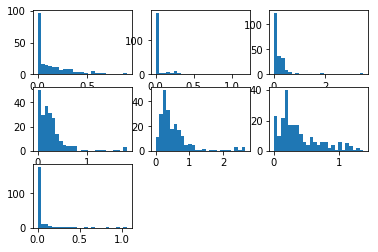

In [83]:
print(encoded.shape)
print(reconstructed_dt.shape)
tenc = encoded.data.numpy() # convert into numpy array
treconst = reconstructed_dt.data.numpy()
originalSignals = signal.data.numpy()
print(tenc.shape)

for i in range(1,8):
    plt.subplot(3,3,i)
    #plt.plot(tenc[1,i,:])
    plt.hist(tenc[7,i,:], bins=25)

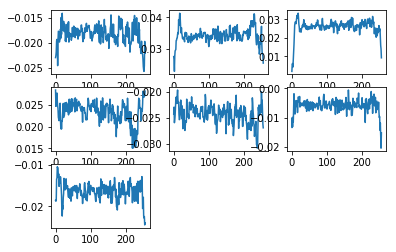

In [87]:
#fig = plt.figure(figsize=(6, 6))
for i in range(1, 8):
    #axes.plt.subplot(treconst[1,1,:])
    plt.subplot(3,3,i)
    #plt.subplot(3, 3, i)
    plt.plot(treconst[1, i, :])
    #plt.plot(originalSignals[1,i,:])

In [78]:
originalSignals.type

<function Tensor.type>

In [44]:
compressedSignal = compressedVectors.detach().cpu()
plt.plot(compressedSignal.numpy()[10,5,1:1000])

NameError: name 'compressedVectors' is not defined

In [73]:
inp = signal.detach().cpu()
out = output.detach().cpu()

NameError: name 'signal' is not defined

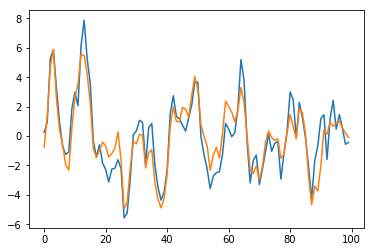

In [73]:
def plot(signal):
    plt.plot(signal.numpy()[2,100,23000:23100])
plot(inp)
plot(out)

# Train the classifier

In [49]:
# The model
fcnet = FCNet(8, ws-32)
device = torch.device('cuda:1')
model = model.to(device=device)
fcnet = fcnet.to(device=device)

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
optimizer = torch.optim.Adam(fcnet.parameters(), lr=lr)

In [ ]:
num_epochs = 1000

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    ############################
    # Train
    ############################    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    episodes = 10
    
    fcnet.train()                   # Put the network into training mode
    for idx in range(episodes):
        for samples in train_dl:
            # Convert torch tensor to Variable
            items = Variable(samples['signal']).to(device=device)
            classes = Variable(samples['label']).to(device=device)
            print(items.shape)
            optimizer.zero_grad()     # Clear off the gradients from any past operation
            encoded_dt = model.encoder(items.float())
            outputs = fcnet(encoded_dt) # Do the forward pass
            loss = criterion(outputs, classes) # Calculate the loss
            iter_loss += loss.data.item()
            loss.backward()           # Calculate the gradients with help of back propagation
            optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
            
            # Record the correct predictions for training data 
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    #train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
    print("Error: %.2f" % (iter_loss/iterations)+ "---- Accuracy: %.2f%%" % (100/episodes * correct.item() / len(train_dl.dataset)))
    #print("Accuracy: %.2f%%" % (100 * correct / len(train_dl.dataset)))

    # computing the validation loss 
    loss = 0.0
    correct = 0
    iterations = 0
    
    # putting the network into evaluation mode 
    fcnet.eval()
    
    for idx in range(10):
        for validSample in valid_dl:
            items = Variable(validSample['signal']).to(device=device)
            classes = Variable(validSample['label']).to(device=device)
            
            outputs = fcnet(model.encoder(items.float()))
            loss += criterion(outputs, classes).data.item()
            #loss += criterion(outputs, classes).data[0]
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1
    
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    valid_accuracy.append(correct.item() / len(valid_dl.dataset) * 100.0 / episodes)
    print ('Val Loss: %.4f,---- Val Acc: %.4f' % (valid_loss[-1], valid_accuracy[-1]))


In [ ]:
torch.cuda.current_device()

In [2]:
torch.cuda.set_device(1)

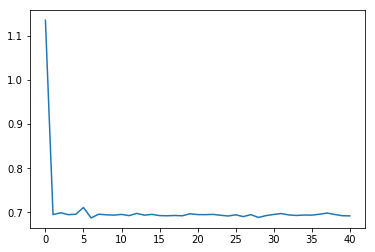

In [17]:
plt.plot(valid_loss)

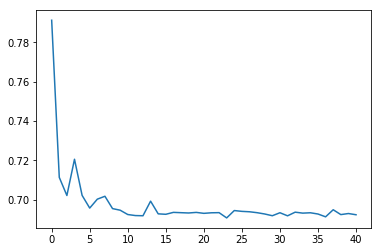

In [16]:
plt.plot(train_loss)

In [ ]:
for samples in train_dl:
    items = Variable(samples['signal']).to(device=device)
    encoded_dt = model.encoder(items.float())q
    